# Chapter 1
## Elliptic Equations and the Finite Element Method


Discretization of partial differential equations with the Finite Element Method resolves three challenges:

* Weak formulation reduces demand on differentiability of solution function.
    
* Has a structured approach of integration adjusted to the underlying meshes.
    
* Polynomial approximations yield a versatile, practical, accurate and efficient method.


### Exercise 1
Consider the problem $$-u''(x) = x^2$$ on the unit interval with $$u(0) = u(1) = 1.$$

Let $$u = \sum_{k=1}^{10} u_k \sin{(\pi k x)} \ \mathrm{and} \ v = \sin{(\pi  l x)} \ \mathrm{for} \ l = 1, ..., 10.$$

Solve $$\int_{\Omega}k\nabla u \cdot \nabla v dx = \int_{\Omega}f v dx + \int_{\Gamma_N}h v ds, \forall v.$$

In [1]:
## Imports
import numpy   as np
import scipy   as sp
import dolfinx as dfx
import matplotlib.pyplot as plt


import ufl

from ufl      import grad, inner, dx
from mpi4py   import MPI
from petsc4py import PETSc

%matplotlib widget

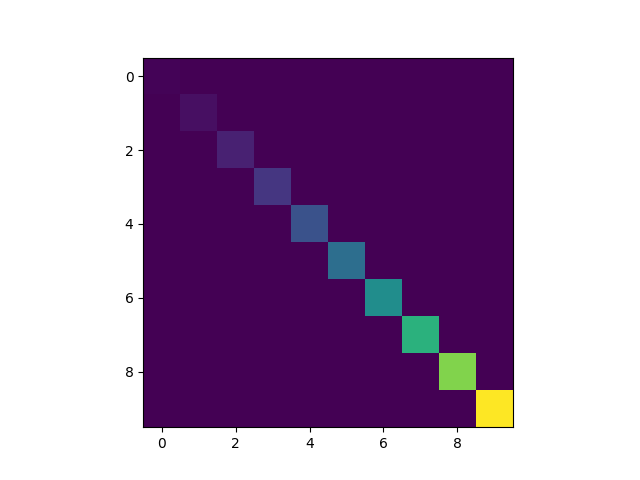

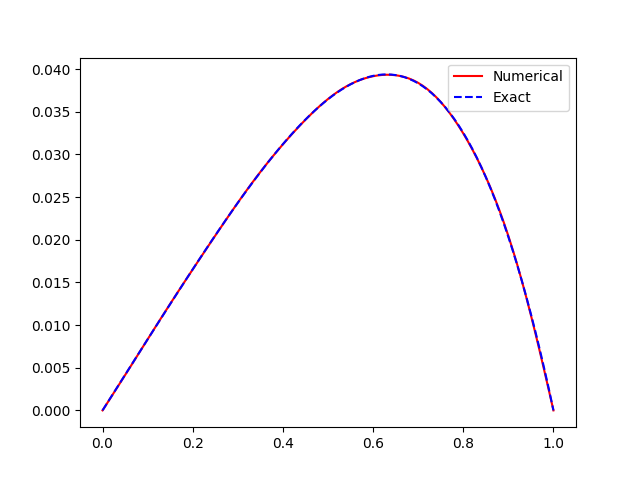

Error norm l2: 5.67e-04
Error norm L2: 5.57e-05
Error norm Linf: 2.21e-04


In [9]:
x = np.linspace(0, 1, 101) # The unit interval
k = l = np.arange(1, 11)

f = x**2 # Source term

A = np.zeros((len(l), len(k))) # Coefficient matrix
b = np.zeros((len(l), 1))      # Right-hand side vector

p = 10 # RHS sinus frequency


# Loop over all indices and fill in matrix and right-hand side vector
for i in l:
    for j in k:
        A[i-1, j-1] = sp.integrate.quad(lambda x: np.pi**2 * i * j * np.cos(np.pi * j * x) * np.cos(np.pi * i * x),
                                    0,
                                    1)[0]
    b[i-1] = sp.integrate.quad(lambda x: x**2 * np.sin(np.pi * i * x),
    #b[i-1] = sp.integrate.quad(lambda x: np.sin(p * np.pi * x) * np.sin(np.pi * i * x),
                              0,
                              1)[0]
plt.figure()
plt.imshow(A)
plt.show()

u = sp.linalg.solve(A, b) # Numerical approximation
u = np.transpose(u)[0] # Convert to row vector

u_fun1 = 0
for i in range(0, len(k - 1)):
    u_fun1 += u[i] * np.sin(np.pi * (i + 1) * x)

u_ex = 1/12 * x * (1 - x**3) # Exact solution
#u_ex = 1/(np.pi * p)**2 * np.sin(p * np.pi * x)

plt.figure()
plt.plot(x, u_fun1, 'r', label = 'Numerical')
plt.plot(x, u_ex, 'b--', label = 'Exact')
plt.legend()
plt.show()
print(f"Error norm l2: {calc_error_l2(u_fun1, u_ex):.2e}")
print(f"Error norm L2: {calc_error_L2(u_fun1, u_ex, x):.2e}")
print(f"Error norm Linf: {np.max(np.abs(u_fun1 - u_ex)):.2e}")

In [2]:
## Utility functions

def calc_error_l2(u_approx, u_exact):
    return np.sqrt(np.sum((u_approx - u_exact) ** 2))

def calc_error_L2(u_approx, u_exact, x):
    f1 = sp.interpolate.interp1d(x, u_approx)
    f2 = sp.interpolate.interp1d(x, u_exact)
    f = lambda x: (f1(x) - f2(x))**2
    return np.sqrt(sp.integrate.quad(f, 0, 1)[0])

def bernstein_polynomial(x, n, k):
    #return sp.special.comb(n, k) * x**k * (1 - x)**(n - k)
    return x**k * (1 - x)**(n - k)

def bernstein_derivative(x, n, k):
    #return sp.special.comb(n, k) * (k - n*x) * (x**(k - 1)) * (1 - x)**((n - 1) - k)
    return (k - n*x) * (x**(k - 1)) * (1 - x)**((n - 1) - k)

### Exercise 2
Consider the same problem $$-u''(x) = x^2$$ on the unit interval with $$u(0) = u(1) = 1.$$

With the Bernstein polynomials of order 10 $$B_k(x) = x^k (1 - x)^{10 - k},$$

solve the problem by letting $$u = \sum_{k=1}^{10} u_k B_k(x) \ \mathrm{and} \ v = B_l(x) \ \mathrm{for} \ l = 1, ..., 10.$$

Only $k = 1, ..., 9$ was considered to impose the Dirichlet boundary condition. The system with homogeneous Neumann BC is singular, because the problem is not determined up until some constant in that case.


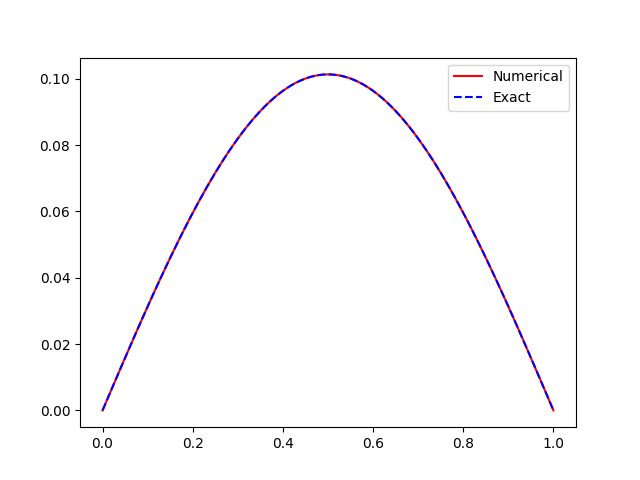

Error norm l2: 2.04e-10
Error norm L2: 2.02e-11
Error norm Linf: 3.25672128154153e-11


In [37]:
x = np.linspace(0, 1, 101) # The unit interval
k = np.arange(1, 10)
l = np.arange(1, 10)

A = np.zeros((len(l), len(k))) # Coefficient matrix
b = np.zeros((len(l), 1))      # Right-hand side vector

n = 10

p = 1 # RHS sinus frequency

# Loop over all indices and fill in matrix and right-hand side vector
for i in l:
    for j in k:
        A[i - 1, j - 1] = sp.integrate.quad(lambda x: bernstein_derivative(x, n, j) * bernstein_derivative(x, n, i),
                                            0,
                                            1)[0]
    
    #b[i - 1] = sp.integrate.quad(lambda x: x**2 * bernstein_polynomial(x, n, i),
    b[i - 1] = sp.integrate.quad(lambda x: np.sin(p * np.pi * x) * bernstein_polynomial(x, n, i),
                                     0,
                                     1)[0]
u = sp.linalg.solve(A, b) # Numerical approximation
u = np.transpose(u)[0] # Convert to row vector

u_fun2 = 0
for i in k:
    u_fun2 += u[i - 1] * bernstein_polynomial(x, n, i)
    
#u_ex = 1/12 * x * (1 - x**3) # Exact solution
u_ex = 1/(np.pi * p)**2 * np.sin(p * np.pi * x)

plt.figure()
plt.plot(x, u_fun2, 'r', label = 'Numerical')
plt.plot(x, u_ex, 'b--', label = 'Exact')
plt.legend()
plt.show()
print(f"Error norm l2: {calc_error_l2(u_fun2, u_ex):.2e}")
print(f"Error norm L2: {calc_error_L2(u_fun2, u_ex, x):.2e}")
print(f"Error norm Linf: {np.max(np.abs(u_fun2 - u_ex))}")

The solution to the problem with $f(x) = x^2$ is exact to machine precision, because the Bernstein polynomials are a basis for the exact solution.

In [26]:
k

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

### Exercise 4
Consider the problem $$-u''(x) = x^2$$ on the unit interval with $$u(0) = u(1) = 1.$$

Solve the problem with the finite element method using FEniCSx, using Lagrange basis functions of order 1, 2 and 3.


Error L2 (assemble) CG1:  9.93549702183547e-17
Error L2 CG1: 		  9.986983001987233e-17
Error l2 CG1: 		  4.456796593659711e-16

Error L2 (assemble) CG2:  1.4468020726838227e-08
Error L2 CG2: 		  1.33543412781872e-08
Error l2 CG2: 		  8.693706259824433e-08

Error L2 (assemble) CG3:  2.7541102779476257e-08
Error L2 CG3: 		  2.742600391122366e-08
Error l2 CG3: 		  2.1342983197756863e-07



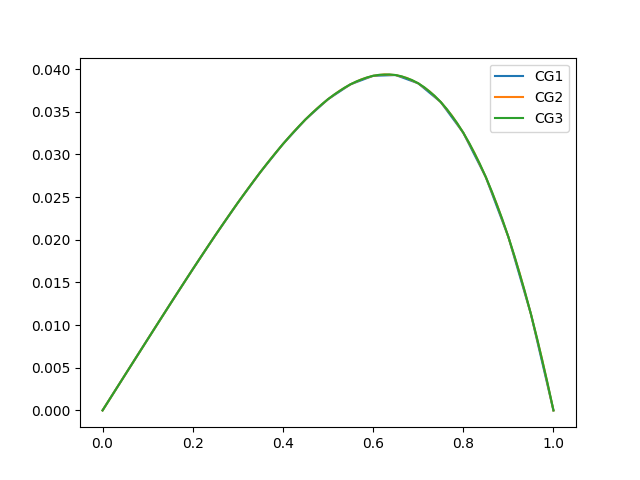

In [47]:
mesh = dfx.mesh.create_unit_interval(MPI.COMM_WORLD, 20)

k = dfx.fem.Constant(mesh, PETSc.ScalarType(1))

class SourceTermExpression:
    def __call__(self, x):
        return x[0]**2
        #return ufl.sin(p * np.pi * x[0])
        

P1 = ufl.FiniteElement("CG", mesh.ufl_cell(), 1)
P2 = ufl.FiniteElement("CG", mesh.ufl_cell(), 2)
P3 = ufl.FiniteElement("CG", mesh.ufl_cell(), 3)

V1 = dfx.fem.FunctionSpace(mesh, P1)
V2 = dfx.fem.FunctionSpace(mesh, P2)
V3 = dfx.fem.FunctionSpace(mesh, P3)


f_expr = SourceTermExpression()
x = ufl.SpatialCoordinate(mesh)

f = f_expr(x)

Vs = [V1, V2, V3]
sol = []
it = 1

for V in Vs:
    u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
    
    # Bilinear and linear forms
    a = inner(k * grad(u), grad(v)) * dx
    L = inner(f, v) * dx
    
    # Set zero Dirichlet BC
    points = dfx.mesh.locate_entities_boundary(mesh, 0,
                                               marker = lambda x: np.logical_or(np.isclose(x[0], 0.0), np.isclose(x[0], 1.0)))
    dofs = dfx.fem.locate_dofs_topological(V = V, entity_dim = 0, entities = points)
    bc = dfx.fem.dirichletbc(value = PETSc.ScalarType(0), dofs = dofs, V = V)
    
    problem = dfx.fem.petsc.LinearProblem(a, L, bcs = [bc])
    u_h = problem.solve()
    
    sol.append(u_h.x.array)
    
    it += 1
    
    
x = [V.tabulate_dof_coordinates()[:,0] for V in Vs]

u_ex = [1/12 * xi * (1 - xi**3) for xi in x]

class ExactFunction:
    def __call__(self, x):
        return 1/12 * x[0] * (1 - x[0] ** 3)
    
u_exact = ExactFunction()


plt.figure()
for i in range(3):
    sort = np.argsort(x[i])
    plt.plot(x[i][sort], sol[i][sort],  label = f"CG{i+1}")
    
    error = dfx.fem.Function(Vs[i])
    error.x.array[:] = sol[i] - u_ex[i]
    
    error_local = dfx.fem.form(inner(error, error) * dx)
    error_local = dfx.fem.assemble_scalar(error_local)
    error_global = mesh.comm.allreduce(error_local, op = MPI.SUM)
    error_global = np.sqrt(error_global)
    
    print(f"Error L2 (assemble) CG{i + 1}: ", error_global)
    print(f"Error L2 CG{i + 1}: \t\t ", calc_error_L2(sol[i], u_ex[i], x[i]))
    print(f"Error l2 CG{i + 1}: \t\t ", calc_error_l2(sol[i], u_ex[i]))
    print("")
    
plt.legend()
plt.show()